In [30]:
import torch

print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Torch: 2.6.0+cu124
CUDA available: True
Using device: cuda


In [31]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms


In [34]:
DATASET_PATH = "/kaggle/input/ucf101-action-recognition"

TRAIN_DIR = os.path.join(DATASET_PATH, "train")
VAL_DIR   = os.path.join(DATASET_PATH, "val")
TEST_DIR  = os.path.join(DATASET_PATH, "test")

SELECTED_CLASSES = [
    "ApplyEyeMakeup",
    "Basketball",
    "Biking",
    "Diving",
    "GolfSwing",
    "HorseRiding",
    "SoccerJuggling",
    "WalkingWithDog"
]

SEQ_LENGTH = 8
IMG_SIZE = 224
BATCH_SIZE = 2
EPOCHS = 15


In [35]:
def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while len(frames) < SEQ_LENGTH:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    cap.release()

    if len(frames) == 0:
        return None

    while len(frames) < SEQ_LENGTH:
        frames.append(frames[-1])

    return frames


In [27]:
def extract_frames(video_path, seq_length=8):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while len(frames) < seq_length:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    cap.release()

    if len(frames) == 0:
        return None

    while len(frames) < seq_length:
        frames.append(frames[-1])

    return np.array(frames)


In [38]:
class UCF101Subset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        self.class_to_idx = {cls:i for i,cls in enumerate(SELECTED_CLASSES)}

        for cls in SELECTED_CLASSES:
            cls_path = os.path.join(root_dir, cls)
            for file in os.listdir(cls_path):
                if file.endswith(".avi"):
                    self.samples.append((os.path.join(cls_path, file),
                                         self.class_to_idx[cls]))

        print(f"Loaded {len(self.samples)} videos from {root_dir}")

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485,0.456,0.406],
                std=[0.229,0.224,0.225]
            )
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        frames = extract_frames(video_path)

        if frames is None:
            return self.__getitem__((idx+1) % len(self.samples))

        frames = torch.stack([
            self.transform(Image.fromarray(f)) for f in frames
        ])

        return frames, label


In [39]:
train_ds = UCF101Subset(TRAIN_DIR)
val_ds   = UCF101Subset(VAL_DIR)
test_ds  = UCF101Subset(TEST_DIR)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)


Loaded 947 videos from /kaggle/input/ucf101-action-recognition/train
Loaded 157 videos from /kaggle/input/ucf101-action-recognition/val
Loaded 163 videos from /kaggle/input/ucf101-action-recognition/test


In [40]:
class ActionModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.cnn = models.resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()

        self.lstm = nn.LSTM(2048, 256, batch_first=True)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.view(b*t, c, h, w)
        feats = self.cnn(x)
        feats = feats.view(b, t, -1)
        out, _ = self.lstm(feats)
        return self.fc(out[:, -1, :])


In [41]:
model = ActionModel(len(SELECTED_CLASSES)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

best_val = float("inf")
patience = 3
wait = 0


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]


In [43]:
train_losses = []
val_losses = []

print("🚀 Training started")
print("Total epochs:", EPOCHS)
print("Early stopping patience:", patience)
print("-" * 50)

for epoch in range(EPOCHS):
    print(f"\n📘 Epoch {epoch+1}/{EPOCHS}")

    # ---------- TRAIN ----------
    model.train()
    running_train_loss = 0.0
    total_train_batches = len(train_loader)

    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        # batch-level print (light)
        if batch_idx % 10 == 0:
            print(f"  🔹 Train batch {batch_idx}/{total_train_batches} | Loss: {loss.item():.4f}")

    avg_train_loss = running_train_loss / total_train_batches
    train_losses.append(avg_train_loss)

    print(f"✅ Epoch {epoch+1} Training Loss: {avg_train_loss:.4f}")

    # ---------- VALIDATION ----------
    model.eval()
    running_val_loss = 0.0
    total_val_batches = len(val_loader)

    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(val_loader):
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / total_val_batches
    val_losses.append(avg_val_loss)

    print(f"🔍 Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")

    # ---------- EARLY STOPPING ----------
    if avg_val_loss < best_val:
        best_val = avg_val_loss
        wait = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("💾 Model improved — saved best_model.pth")
    else:
        wait += 1
        print(f"⏳ No improvement | Early stop counter: {wait}/{patience}")
        if wait >= patience:
            print("⏹ Early stopping triggered")
            break

print("\n🎉 Training finished")


🚀 Training started
Total epochs: 15
Early stopping patience: 3
--------------------------------------------------

📘 Epoch 1/15
  🔹 Train batch 0/474 | Loss: 0.2809
  🔹 Train batch 10/474 | Loss: 1.1020
  🔹 Train batch 20/474 | Loss: 0.3155
  🔹 Train batch 30/474 | Loss: 0.2464
  🔹 Train batch 40/474 | Loss: 0.5447
  🔹 Train batch 50/474 | Loss: 0.0720
  🔹 Train batch 60/474 | Loss: 0.0722
  🔹 Train batch 70/474 | Loss: 0.0278
  🔹 Train batch 80/474 | Loss: 0.0712
  🔹 Train batch 90/474 | Loss: 0.0282
  🔹 Train batch 100/474 | Loss: 0.7077
  🔹 Train batch 110/474 | Loss: 0.2577
  🔹 Train batch 120/474 | Loss: 0.0696
  🔹 Train batch 130/474 | Loss: 0.5623
  🔹 Train batch 140/474 | Loss: 0.8513
  🔹 Train batch 150/474 | Loss: 0.0487
  🔹 Train batch 160/474 | Loss: 0.0734
  🔹 Train batch 170/474 | Loss: 0.0984
  🔹 Train batch 180/474 | Loss: 1.7418
  🔹 Train batch 190/474 | Loss: 0.0974
  🔹 Train batch 200/474 | Loss: 1.0737
  🔹 Train batch 210/474 | Loss: 0.0784
  🔹 Train batch 220/474 |

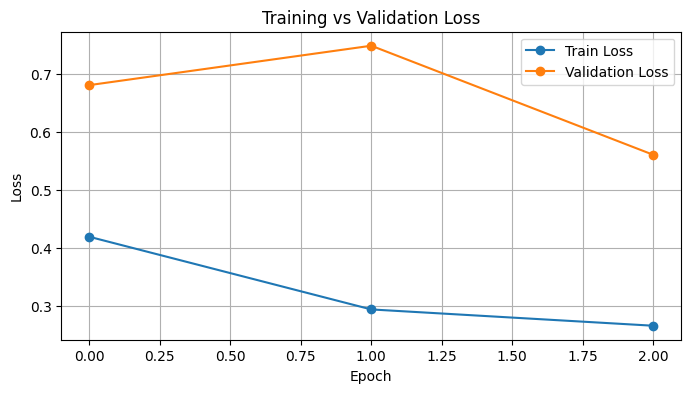

📊 Final Train Loss: 0.26621096651757503
📊 Final Val Loss: 0.5611722823939745


In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

print("📊 Final Train Loss:", train_losses[-1])
print("📊 Final Val Loss:", val_losses[-1])


In [45]:
def evaluate_accuracy(loader, name=""):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    acc = correct / total
    print(f"🎯 {name} Accuracy: {acc*100:.2f}%")
    return acc

train_acc = evaluate_accuracy(train_loader, "Train")
val_acc   = evaluate_accuracy(val_loader, "Validation")


🎯 Train Accuracy: 96.73%
🎯 Validation Accuracy: 82.80%


In [50]:
print("\n🧪 Testing on 3 sample videos\n")

model.load_state_dict(torch.load("best_model.pth"))
model.eval()

for i in range(3):
    frames, label = test_ds[i]
    frames = frames.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(frames).argmax(1).item()

    print(f"Sample {i+1}")
    print("  ✅ True Label:", SELECTED_CLASSES[label])
    print("  🤖 Predicted :", SELECTED_CLASSES[pred])
    print("-" * 30)



🧪 Testing on 3 sample videos

Sample 1
  ✅ True Label: ApplyEyeMakeup
  🤖 Predicted : ApplyEyeMakeup
------------------------------
Sample 2
  ✅ True Label: ApplyEyeMakeup
  🤖 Predicted : ApplyEyeMakeup
------------------------------
Sample 3
  ✅ True Label: ApplyEyeMakeup
  🤖 Predicted : ApplyEyeMakeup
------------------------------


In [52]:
from torchvision import transforms
from PIL import Image

def predict_action_from_file(file_path):
    print("📥 Received file:", file_path)

    # Video
    if file_path.endswith(".avi") or file_path.endswith(".mp4"):
        print("🎥 Detected video input")
        frames = extract_frames(file_path)
        frames = torch.stack([
            transforms.ToTensor()(Image.fromarray(f)) for f in frames
        ]).unsqueeze(0).to(device)

    # Image
    else:
        print("🖼 Detected image input")
        img = Image.open(file_path).convert("RGB")
        img = img.resize((IMG_SIZE, IMG_SIZE))
        img = transforms.ToTensor()(img)
        frames = img.unsqueeze(0).unsqueeze(0).repeat(1, SEQ_LENGTH, 1, 1, 1).to(device)

    model.eval()
    with torch.no_grad():
        idx = model(frames).argmax(1).item()

    action = SELECTED_CLASSES[idx]
    print("✅ Predicted Action:", action)
    return action


In [53]:
print("🔄 Loading best trained model...")

model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

print("✅ Model loaded and set to eval mode")


🔄 Loading best trained model...
✅ Model loaded and set to eval mode


In [55]:
from fastapi import FastAPI, UploadFile, File
import uvicorn
import shutil

app = FastAPI(title="Action Recognition API")

UPLOAD_DIR = "uploads"
os.makedirs(UPLOAD_DIR, exist_ok=True)

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    print("📥 API received file:", file.filename)

    file_path = os.path.join(UPLOAD_DIR, file.filename)
    with open(file_path, "wb") as buffer:
        shutil.copyfileobj(file.file, buffer)

    action = predict_action_from_file(file_path)

    print("📤 API response:", action)
    return {
        "filename": file.filename,
        "predicted_action": action
    }


In [56]:
import threading

def run_api():
    print("🚀 Starting FastAPI server on http://127.0.0.1:8000")
    uvicorn.run(app, host="127.0.0.1", port=8000, log_level="info")

api_thread = threading.Thread(target=run_api, daemon=True)
api_thread.start()


🚀 Starting FastAPI server on http://127.0.0.1:8000


INFO:     Started server process [47]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


In [57]:
import requests

sample_video = test_ds[0][0]  # just for confirmation
print("🧪 API is running. Ready for frontend.")


🧪 API is running. Ready for frontend.


In [58]:
import gradio as gr
import requests

API_URL = "http://127.0.0.1:8000/predict"

def gradio_api_call(file):
    print("🌐 Frontend sending file to API:", file.name)

    with open(file.name, "rb") as f:
        response = requests.post(
            API_URL,
            files={"file": f}
        )

    result = response.json()
    print("🌐 Frontend received response:", result)

    return f"🧠 Predicted Action: {result['predicted_action']}"


In [61]:
import gradio as gr
import requests
import os
import glob

API_URL = "http://127.0.0.1:8000/predict"
DATASET_ROOT = "/kaggle/input"

# --------------------------------------------------
# AUTO-FIND SAMPLE VIDEOS FROM DATASET
# --------------------------------------------------
def find_sample_video(class_name):
    pattern = f"{DATASET_ROOT}/**/test/{class_name}/*.avi"
    matches = glob.glob(pattern, recursive=True)
    print(f"🔍 Searching for {class_name} → Found {len(matches)} videos")
    return matches[0] if len(matches) > 0 else None

SAMPLE_VIDEOS = {
    "Basketball": find_sample_video("Basketball"),
    "Biking": find_sample_video("Biking"),
    "WalkingWithDog": find_sample_video("WalkingWithDog"),
}

print("✅ Sample video paths resolved:")
for k, v in SAMPLE_VIDEOS.items():
    print(f"{k}: {v}")

# --------------------------------------------------
# API CALL (USED BY BOTH BUTTONS & UPLOAD)
# --------------------------------------------------
def call_api_with_path(video_path):
    if video_path is None or not os.path.exists(video_path):
        return "❌ Video file not found"

    print("🌐 Sending file to API:", video_path)

    with open(video_path, "rb") as f:
        response = requests.post(
            API_URL,
            files={"file": f}
        )

    result = response.json()
    print("📤 API Response:", result)

    return f"🧠 Predicted Action: {result['predicted_action']}"

# --------------------------------------------------
# USER UPLOAD HANDLER
# --------------------------------------------------
def handle_user_upload(file):
    if file is None:
        return "❌ No file uploaded"

    print("📥 User uploaded file:", file.name)
    return call_api_with_path(file.name)

# --------------------------------------------------
# GRADIO UI
# --------------------------------------------------
with gr.Blocks(title="Action Recognition System") as demo:

    gr.Markdown("# 🎥 Action Recognition System")
    gr.Markdown(
        "**Frontend → API → ResNet50 + LSTM → Prediction**  \n"
        "• Click a button to test a sample video  \n"
        "• Or upload your own image/video"
    )

    output = gr.Textbox(label="Action Caption", interactive=False)

    # ---------- BUTTONS ----------
    gr.Markdown("## ▶️ Quick Test (Sample Videos)")
    with gr.Row():
        btn_basketball = gr.Button("🏀 Test Basketball")
        btn_biking = gr.Button("🚴 Test Biking")
        btn_walking = gr.Button("🚶 Test WalkingWithDog")

    btn_basketball.click(
        fn=lambda: call_api_with_path(SAMPLE_VIDEOS["Basketball"]),
        outputs=output
    )
    btn_biking.click(
        fn=lambda: call_api_with_path(SAMPLE_VIDEOS["Biking"]),
        outputs=output
    )
    btn_walking.click(
        fn=lambda: call_api_with_path(SAMPLE_VIDEOS["WalkingWithDog"]),
        outputs=output
    )

    gr.Markdown("---")

    # ---------- USER UPLOAD ----------
    gr.Markdown("## 📤 Upload Your Own Image / Video")
    upload = gr.File(label="Upload Image or Video (.avi, .mp4, .png, .jpg)")
    upload_btn = gr.Button("Submit Upload")

    upload_btn.click(
        fn=handle_user_upload,
        inputs=upload,
        outputs=output
    )

    gr.Markdown("---")
    gr.Markdown(
        "ℹ️ **Note:** Model is trained on UCF101 action videos. "
        "For best results, upload short action videos."
    )

print("🎨 Launching final frontend (buttons + upload)...")
demo.launch(share=True)


🔍 Searching for Basketball → Found 34 videos
🔍 Searching for Biking → Found 17 videos
🔍 Searching for WalkingWithDog → Found 16 videos
✅ Sample video paths resolved:
Basketball: /kaggle/input/ucf101-action-recognition/test/Basketball/v_BasketballDunk_g22_c02.avi
Biking: /kaggle/input/ucf101-action-recognition/test/Biking/v_Biking_g07_c02.avi
WalkingWithDog: /kaggle/input/ucf101-action-recognition/test/WalkingWithDog/v_WalkingWithDog_g09_c03.avi
🎨 Launching final frontend (buttons + upload)...
* Running on local URL:  http://127.0.0.1:7862
* Running on public URL: https://cbccad24ed7241e16d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


🌐 Sending file to API: /kaggle/input/ucf101-action-recognition/test/WalkingWithDog/v_WalkingWithDog_g09_c03.avi
📥 API received file: v_WalkingWithDog_g09_c03.avi
📥 Received file: uploads/v_WalkingWithDog_g09_c03.avi
🎥 Detected video input
✅ Predicted Action: WalkingWithDog
📤 API response: WalkingWithDog
📤 API Response: {'filename': 'v_WalkingWithDog_g09_c03.avi', 'predicted_action': 'WalkingWithDog'}
